In [6]:
import keras
# from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, UpSampling2D, MaxPooling2D
import numpy as np

import soundfile as sf
import pandas as pd
import librosa
import matplotlib.pyplot as plt

%matplotlib inline

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train[0].shape

img1=X_train[1, :, :]
np.sum( img1 ) / (img1.shape[0] * img1.shape[1])

In [274]:
def make_autoencoder(input_img):
    encoding_dim = 64

    input_img = Input(shape=(400,))
    encoded = Dense(encoding_dim, activation="relu")(input_img)

    decoded = Dense(400, activation="tanh")(encoded)

    autoencoder = Model(input=input_img, output=decoded)

    encoder = Model(input=input_img, output=encoded)

    encoded_input = Input(shape=(encoding_dim,))

    decoder_layer = autoencoder.layers[-1]

    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input) )

    autoencoder.compile( optimizer="adadelta", loss="categorical_crossentropy" )
    return autoencoder

In [7]:
def make_convolutional_autoencoder(input_img):
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
    x = MaxPooling2D((2, 2), border_mode='same')(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), border_mode='same')(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    encoded = MaxPooling2D((2, 2), border_mode='same')(x)

    # at this point the representation is (8, 4, 4) i.e. 128-dimensional

    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
    return autoencoder


In [3]:
autoencoder = make_convolutional_autoencoder()

NameError: global name 'Convolution2D' is not defined

In [121]:
plot_files = [ "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/air_conditioner/147926.wav",
             "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/jackhammer/162134.wav",
              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/drilling/165644.wav",
              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/siren/159738.wav",
#              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/gun_shot/158977.wav",
#              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/dog_bark/170015.wav",
              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/children_playing/182739.wav",
              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/engine_idling/144068.wav",
#               "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/car_horn/162702.wav",
              "/Users/zhouqiang/Downloads/urbansound/UrbanSound/data/street_music/157940.wav"
             ]

# plot_labels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_labels = [ 0, 1, 2, 3, 6, 7, 9]

In [203]:
def make_dataset(test_files, labels, start_index=0):
    X_train=np.empty( (len(test_files) * 10, 20, 20) )
    X_test=np.empty( (len(test_files) * 10, 20, 20) )
    y_test = []
    y_train = []
    i_counter = 0
    for test_file, label in zip(test_files, labels):
        y, sr = sf.read(test_file)
        y=y[:,0]
        mfcc = librosa.feature.mfcc(y=y, sr=sr)

#         window_size = 100
        window_size = 20

        length = mfcc.shape[1]
        print "length is ", length
        if length > 200:
            length = 200
        n_plots = length / window_size

        ix_plot = list(np.arange( length ))[ : : window_size ]
        
        for i, idx in enumerate(ix_plot):
#             print i, idx
            X_train[ i_counter + i ] = mfcc[:, idx : idx+window_size]
            X_test[ i_counter + i ] = mfcc[:, idx+length : idx+length+window_size]
        i_counter += i+1

        for j in range(10):
            y_train.append(label)
            y_test.append(label)
    return X_train, y_train, X_test, y_test
    

In [204]:
X_train, y_train, X_test, y_test = make_dataset(plot_files, plot_labels)

length is  9665
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  64091
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  575
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  4454
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  19192
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  18715
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180
length is  1659
0 0
1 20
2 40
3 60
4 80
5 100
6 120
7 140
8 160
9 180


In [269]:
a=X_train.flatten()

In [270]:
a.min(), a.max(), a.mean()

(-648.67923032415092, 236.86616148408748, -6.277652288375192)

In [271]:
b=X_test.flatten()
b.min(), b.max(), b.mean(), X_test.shape, X_train.shape

(-642.27491099432632,
 241.47310821188125,
 -5.468363454474046,
 (70, 20, 20),
 (70, 20, 20))

In [155]:
X_train_reshape = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_reshape = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [256]:
# for i in range(70):
#     print X_train[i].max(), X_train[i].min(), X_train[i].shape
# pd.DataFrame(y_test).hist()

def rearrange_tuple_grid(grid):
    col_1, col_2 = [], []
    for i in np.arange( len(grid) ):
        col_1.append(grid[i][0])
        col_2.append(grid[i][1])
    return col_1, col_2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127c89510>]], dtype=object)

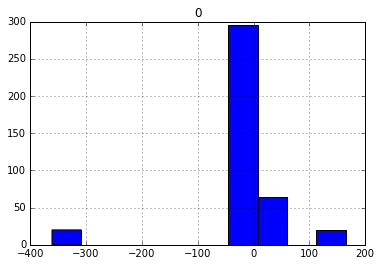

In [261]:
pd.DataFrame( X_train[i+40].flatten()).hist()

[ -3.34328939e+02   1.79418861e+02   4.45272225e+00  -1.04491252e+01
   1.79503452e+01  -2.84699203e+00  -8.52555139e+00   2.95523861e+00
  -3.14971369e+00  -5.09924043e+00   2.68997661e+00   2.72783252e+00
   8.72237045e-02  -1.32946480e+00  -1.63376345e+00   5.71168124e+00
   1.09152658e+01   4.94501642e+00   1.30407655e+00   2.60106731e+00] [-364.47087051  169.3795768    -6.26593069   16.6231322   -16.37948966
   -4.23164114   -1.20194312    1.01700155   15.58750701   -4.31787933
   -7.11336368   -6.69616104    2.41597519   -1.43374928   -3.82046213
    5.0974766    -3.30081237    3.65789242    6.61428854    4.9050286 ]
9082.90081208 7216.70981674
[ -3.38788752e+02   1.77963362e+02   5.74625326e+00  -1.60671675e+01
   1.31113871e+01   5.13531486e+00   1.27709290e+00   1.62444292e+00
  -4.37715887e+00   2.47911700e+00   7.61158135e+00   7.21079733e-01
  -7.15212844e-02   2.20124746e+00   1.92869401e+00   7.49132676e+00
   1.07734823e+01   5.86687554e+00   3.34325414e+00   2.31106066e

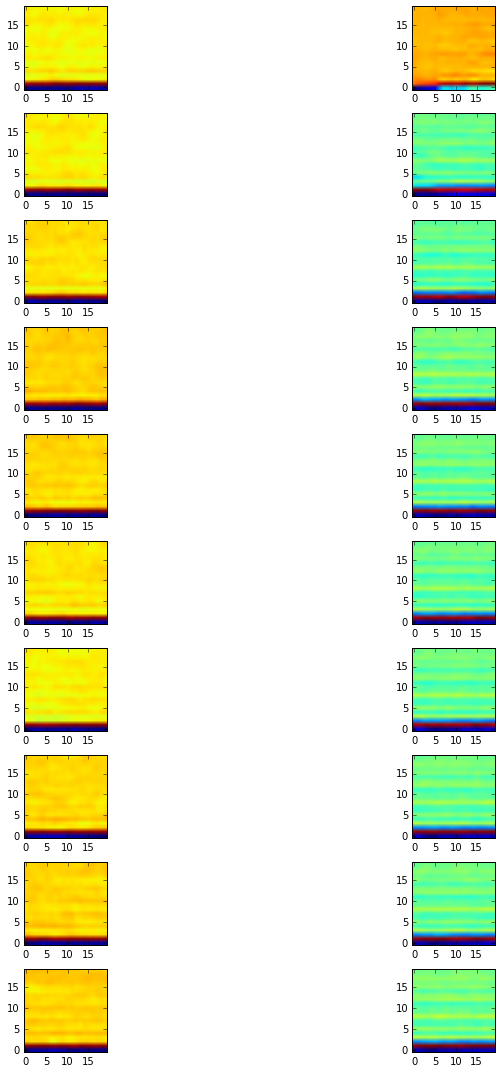

In [267]:
f, tuples_grid = plt.subplots( 10, 2, figsize=(15, 15) )
tuples_grid = rearrange_tuple_grid(tuples_grid)
# rows, cols = len(tuples_grid), len(tuples_grid[0])
for i, (x, ax_col) in enumerate( list(zip( tuples_grid[0], tuples_grid[1])) ):
#     x.imshow( librosa.feature.delta(X_train[i]), origin="leftbottom")
#     x.imshow( librosa.feature.delta(X_train[i + 10]), origin="leftbottom")
#     x.imshow( librosa.feature.delta(X_train[i + 20]), origin="leftbottom")

#     x.imshow( librosa.feature.delta(X_train[i + 60]), origin="leftbottom")
#     ax_col.imshow( librosa.feature.delta(X_train[i + 10]), origin="leftbottom")
    
    x.imshow( X_train[i + 40], origin="leftbottom")
    ax_col.imshow( X_train[i + 20], origin="leftbottom")
    print np.mean( X_train[i+40], axis=1), np.mean( X_train[i+20], axis=1 )
    print np.var( X_train[i+20] ), np.var( X_train[i+40])
plt.tight_layout()

In [275]:
autoencoder.fit(X_train_reshape, X_train_reshape, nb_epoch=50, 
                batch_size=8, shuffle=True, validation_data=(X_test_reshape, X_test_reshape))

Train on 70 samples, validate on 70 samples
Epoch 1/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 2/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 3/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 4/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 5/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 6/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 7/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 8/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 9/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 10/50
70/70 [==============================] - 0s - loss: nan - val_loss: -3.6374e-05
Epoch 11/50
70/70 [==========================

In [208]:
encoded_imgs = encoder.predict(X_test_reshape)
decoded_imgs = decoder.predict(encoded_imgs)

In [245]:
for x, y in zip(list(np.arange(10)), list(np.arange(10))):
    print x, y

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [249]:
# print encoded_imgs.shape
for i, (x, y) in enumerate(list(zip(list(np.arange(10)), list(np.arange(10))))):
    print i, x, y

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9


In [210]:
decoded_imgs_re = decoded_imgs.reshape((70, 20, 20))

In [221]:
print decoded_imgs_re[69]

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  na

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131629e90>]], dtype=object)

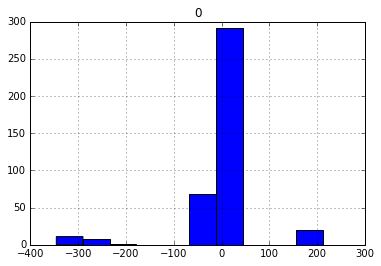

In [211]:
pd.DataFrame( X_test_reshape[0] ).hist()

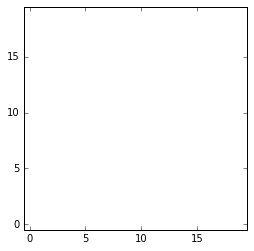

In [212]:
plt.imshow( decoded_imgs_re[0], origin="leftbottom" )

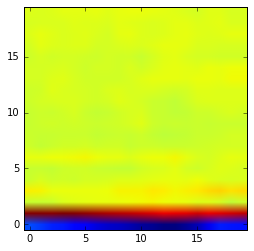

In [162]:
plt.imshow( X_test[0], origin="leftbottom")